# IMPORTS

Por incompatibilidades entre librerias nos vemos obligados a hacer este workaround para que solucionar los problemas de dependencias.

In [50]:
import  scipy.signal.signaltools
import numpy as np

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered
import pandas as pd
import matplotlib.pyplot as plt
# import os
# import pickle
import pytorch_forecasting
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
import torch
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss, MAPE
from lightning.pytorch.tuner import Tuner
from  scipy.signal.signaltools import _centered
# from tft_helper import (
#     get_best_lr,
#     tft_trainer,
#     tft_predict,
#     run_hyperparameter_optimization,
#     buildLaggedFeatures,
#     make_preds,
#     add_sma,
#     add_ema,
#     add_rsi,
#     add_macd,
#     add_bollinger_bands
# )

from tft_helper import *

In [51]:

import pandas as pd
import os
import sys
basepath = os.path.abspath('') # script directory

sys.path.insert(1, os.path.join(basepath, "..\\"))
from datetime import datetime, timedelta


In [52]:
def clean_numeric_column(column):
    return column.str.replace(".", "", regex=False).str.replace(",", ".").astype(float)


# Función para limpiar la columna de volumen
def clean_volume_column(column):
    column = column.str.replace("B", "e9", regex=False).str.replace("M", "e6", regex=False)
    return column.str.replace(".", "", regex=False).str.replace(",", ".").astype(float)


# Función para limpiar columnas de porcentaje
def clean_percentage_column(column):
    return column.str.replace("%", "", regex=False).str.replace(",", ".").astype(float)


def add_sma(df, period):
    df[f"SMA_{period}"] = df["target"].rolling(window=period).mean()
    return df


def add_ema(df, period):
    df[f"EMA_{period}"] = df["target"].ewm(span=period, adjust=False).mean()
    return df


def add_rsi(df, period=14):
    delta = df["target"].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    df[f"RSI_{period}"] = 100 - (100 / (1 + rs))
    return df


def add_macd(df, short_period=12, long_period=26, signal_period=9):
    short_ema = df["target"].ewm(span=short_period, adjust=False).mean()
    long_ema = df["target"].ewm(span=long_period, adjust=False).mean()
    df["MACD"] = short_ema - long_ema
    df["Signal_Line"] = df["MACD"].ewm(span=signal_period, adjust=False).mean()
    return df


def add_bollinger_bands(df, period=20):
    sma = df["target"].rolling(window=period).mean()
    std = df["target"].rolling(window=period).std()

    df[f"Bollinger_Upper_{period}"] = sma + (std * 2)
    df[f"Bollinger_Lower_{period}"] = sma - (std * 2)
    return df


def add_cci(df, period=20):
    typical_price = df["target"]
    sma = typical_price.rolling(window=period).mean()
    mean_deviation = typical_price.rolling(window=period).apply(
        lambda x: np.mean(np.abs(x - np.mean(x))), raw=True
    )
    df[f"CCI_{period}"] = (typical_price - sma) / (0.015 * mean_deviation)
    return df


def add_atr(df, period=14):
    df["High_Low"] = df["target"].rolling(window=1).max() - df["target"].rolling(window=1).min()
    df["High_Close"] = abs(df["target"] - df["target"].shift(1))
    df["Low_Close"] = abs(df["target"].shift(1) - df["target"])
    df["True_Range"] = df[["High_Low", "High_Close", "Low_Close"]].max(axis=1)
    df[f"ATR_{period}"] = df["True_Range"].rolling(window=period).mean()
    df.drop(columns=["High_Low", "High_Close", "Low_Close", "True_Range"], inplace=True)
    return df


def add_roc(df, period=12):
    df[f"ROC_{period}"] = df["target"].pct_change(periods=period) * 100
    return df


def add_stochastic(df, period=14):
    df[f"Stochastic_{period}_K"] = 100 * (
        (df["target"] - df["target"].rolling(window=period).min())
        / (df["target"].rolling(window=period).max() - df["target"].rolling(window=period).min())
    )
    df[f"Stochastic_{period}_D"] = df[f"Stochastic_{period}_K"].rolling(window=3).mean()
    return df


def add_williams_r(df, period=14):
    high = df["target"].rolling(window=period).max()
    low = df["target"].rolling(window=period).min()
    df[f"Williams_%R_{period}"] = -100 * (high - df["target"]) / (high - low)
    return df


# def add_parabolic_sar(df, af=0.02, max_af=0.2):
#     df["SAR"] = tal.sar(high=df["target"], low=df["target"], af=af, max_af=max_af)
#     return df


def add_ichimoku(df):
    ichimoku = ta.ichimoku(high=df["target"], low=df["target"], close=df["target"], return_as="df")
    df = pd.concat([df, ichimoku[0]], axis=1)
    return df


def buildLaggedFeatures(s, lag=2, cols=[], dropna=True):
    """
    Builds a new DataFrame to facilitate regressing over all possible lagged features
    """
    if type(s) is pd.DataFrame:
        new_dict = {}
        for col_name in cols:
            # new_dict[col_name] = s[col_name]
            # create lagged Series
            for l in range(1, lag + 1):
                new_dict["%s_lag%d" % (col_name, l)] = s[col_name].shift(l)
        res = pd.DataFrame(new_dict, index=s.index)

    elif type(s) is pd.Series:
        the_range = range(lag + 1)
        res = pd.concat([s.shift(i) for i in the_range], axis=1)
        res.columns = ["lag_%d" % i for i in the_range]
    else:
        print("Only works for DataFrame or Series")
        return None
    if dropna:
        return res.dropna()
    else:
        return res

# PARAMS

In [81]:
seq_len = 1 #sequence lenght: how many timesteps does a sequence have
pred_len = 5 # prediction lenght: how many timesteps does a prediction sequence have
n_prev_len = seq_len *  25 # number of previous timesteps to take for inference
n_preds = 5 # number of predictions with test data
test_len = pred_len * n_preds  # number of timesteps to use for test data
group = 'month'
n_lags = seq_len * 4  # number of lags to use
loss = MAPE()
# raw_df_agg = "Timestamp_hour"  # Timestamp_minutes
epochs = 75


lr_finder = False
grid_search = False

# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
# logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard


# TFT params
# tft_params =  {'gradient_clip_val': 0.05808054277495504, 'hidden_size': 32, 'dropout': 0.2997107370422699, 'hidden_continuous_size': 19, 'attention_head_size': 2, 'learning_rate': 0.017853144294677083}
# tft_params =  {'gradient_clip_val': 0.01, 'hidden_size': 36, 'dropout': 0.3, 'hidden_continuous_size': 22, 'attention_head_size': 4, 'learning_rate': 0.001}
# tft_params = {'gradient_clip_val': 0.35, 'hidden_size': 8, 'dropout': 0.1, 'hidden_continuous_size': 8, 'attention_head_size': 4, 'learning_rate': 0.01}
tft_params =  {'gradient_clip_val': 0.03, 'hidden_size': 24, 'dropout': 0.25, 'hidden_continuous_size': 24, 'attention_head_size': 4, 'learning_rate': 0.01, 'loss': loss}


hyperparams_grid = {
    "gradient_clip_val_range": (0.01, 1.0),
    "hidden_size_range": (8, 64),
    "hidden_continuous_size_range": (8, 64),
    "attention_head_size_range": (1, 4),
    "learning_rate_range": (0.001, 0.3),
    "dropout_range": (0.1, 0.3),
    "trainer_kwargs": dict(limit_train_batches=60),
    "reduce_on_plateau_patience": 4,
    "use_learning_rate_finder": False
}

va bien:
tft_params =  {'gradient_clip_val': 0.03, 'hidden_size': 24, 'dropout': 0.25, 'hidden_continuous_size': 24, 'attention_head_size': 4, 'learning_rate': 0.01, group: 'month', n_prev_hours: 10*7, lags: {'target': list(range(1,11))}}

    

# LOAD DATA

In [54]:
import pandas as pd

# Cargar el dataset
file_path = "./data/Datos históricos del IBEX 35.csv"
df = pd.read_csv(file_path)
df = df[::-1].reset_index(drop=True)
df["Fecha"] = pd.to_datetime(df["Fecha"], format="%d.%m.%Y")

# Aplicar las transformaciones
df["Último"] = clean_numeric_column(df["Último"])
df["Apertura"] = clean_numeric_column(df["Apertura"])
df["Máximo"] = clean_numeric_column(df["Máximo"])
df["Mínimo"] = clean_numeric_column(df["Mínimo"])
df["Vol."] = clean_volume_column(df["Vol."])
df["% var."] = clean_percentage_column(df["% var."])

# Eliminar la columna 'Fecha'
df = df.rename(
    columns={
        "Fecha": "fechaHora",
        "Vol.": "vol",
        "% var.": "var",
        "Último": "target",
        "Máximo": "max",
        "Mínimo": "min",
        "Apertura": "open",
    }
)
# df = df.iloc[::-1]
df = df.reset_index(drop=True)
# df = df[:-1]
# Guardar el dataframe limpio en un nuevo archivo CSV
# df_numeric.to_csv('ruta/a/tu/archivo/ibex35_cleaned.csv', index=False)

## ADD INDICATORS


In [55]:
lags = buildLaggedFeatures(df, n_lags, ["target"])
df = pd.concat([df, lags], axis=1)
periods = [5, 10, 15, 20]

# Supongamos que df es tu DataFrame
for i in periods:
    df = add_sma(df, period=i)
    df = add_ema(df, period=i)
for i in [6, 10, 14]:
    df = add_rsi(df, period=i)
for i in periods:
    df = add_bollinger_bands(df, period=i)
df = add_macd(df)

for i in periods:
    df = add_atr(df, period=i)

# Agregar CCI con diferentes períodos
for i in periods:
    df = add_cci(df, period=i)

# Agregar ROC con diferentes períodos
for i in [10, 14, 20, 50]:
    df = add_roc(df, period=i)

# Agregar Stochastic Oscillator con diferentes períodos
for i in [10, 14, 20, 25, 50]:
    df = add_stochastic(df, period=i)

# Agregar Williams %R con diferentes períodos
for i in [10, 14]:
    df = add_williams_r(df, period=i)

# Agregar Parabolic SAR (sin período, pero podrías ajustar los factores de aceleración)
# data = add_parabolic_sar(data)

# Agregar Ichimoku Cloud (no requiere período)
# df = add_ichimoku(df)

# Calculate ATR (Average True Range)

# df['ATR'] = ta.ATR(df['max'], df['min'], df['close'], timeperiod=14)

# Calculate ADX (Average Directional Index)
# df['ADX'] = ta.ADX(df['max'], df['min'], df['close'], timeperiod=14)


# # Calculate CCI (Commodity Channel Index)
# df['CCI'] = ta.CCI(df['max'], df['min'], df['close'], timeperiod=14)

# # Calculate OBV (On-Balance Volume)
# df['OBV'] = ta.OBV(df['close'], df['vol'])

# # Calculate Stochastic Oscillator (SlowK, SlowD)
# df['SlowK'], df['SlowD'] = ta.STOCH(df['max'], df['min'], df['close'], fastk_period=14, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)

# df['WilliamsR'] = ta.WILLR(df['max'], df['min'], df['close'], timeperiod=14)


,fechaHora,target,open,max,min,vol,var,target_lag1,target_lag2,target_lag3,...,Stochastic_14_K,Stochastic_14_D,Stochastic_20_K,Stochastic_20_D,Stochastic_25_K,Stochastic_25_D,Stochastic_50_K,Stochastic_50_D,Williams_%R_10,Williams_%R_14
0,2021-01-04,8099.2,8191.8,8207.2,8053.0,213150000.0,0.32,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-05,8091.5,8052.2,8118.1,8037.4,173800000.0,-0.10,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-06,8350.3,8179.8,8383.7,8134.1,275700000.0,3.20,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-07,8385.8,8383.8,8399.5,8274.1,247340000.0,0.43,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-08,8407.7,8439.7,8439.7,8366.2,204980000.0,0.26,8385.8,8350.3,8091.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932,2024-08-19,11102.5,10968.8,11112.4,10966.9,76900000.0,1.40,10949.7,10885.6,10753.0,...,68.858515,58.153758,68.012649,57.439390,68.012649,55.907328,57.846281,47.020857,-0.000000,-31.141485
933,2024-08-20,11087.8,11130.5,11151.9,11056.5,68430000.0,-0.13,11102.5,10949.7,10885.6,...,100.000000,76.607971,86.596935,71.608692,86.596935,70.724219,82.781072,63.144843,-0.000000,-0.000000
934,2024-08-21,11114.9,11080.8,11127.2,11066.3,66680000.0,0.24,11087.8,11102.5,10949.7,...,97.935393,88.931303,85.078087,79.895890,84.809049,79.806211,81.071968,73.899774,-2.699725,-2.064607
935,2024-08-22,11156.3,11110.4,11207.5,11107.4,73240000.0,0.37,11114.9,11087.8,11102.5,...,100.000000,99.311798,89.200837,86.958620,88.105084,86.503689,84.222765,82.691935,-0.000000,-0.000000


In [ ]:
cols_to_shift = df.columns[27:]
# Desplazar los valores en las columnas seleccionadas
df[cols_to_shift] = df[cols_to_shift].shift(1)
df

In [57]:
data = df.copy()
data["month"] = 1
data["week"] = (
    data["fechaHora"].dt.strftime("%Y-%U").astype(str).astype("category").cat.codes
)
# data['day'] = data['fechaHora'].dt.day.astype('category').cat.codes

data["day"] = (data["fechaHora"] - data["fechaHora"].min()).dt.days
# data["hour"] = data["fechaHora"].dt.hour

# data['time_idx'] = data.groupby(group).cumcount()

data["time_idx"] = data.index

# data['Low'].fillna(method='ffill', inplace=True)
# data['High'].fillna(method='ffill', inplace=True)


In [58]:
full = data.copy()

data = full[:-test_len]
test = full[-test_len:]
data = data.reset_index(drop=True)
data = data.dropna()

In [59]:
data

,fechaHora,target,open,max,min,vol,var,target_lag1,target_lag2,target_lag3,...,Stochastic_25_K,Stochastic_25_D,Stochastic_50_K,Stochastic_50_D,Williams_%R_10,Williams_%R_14,month,week,day,time_idx
52,2021-03-17,8599.5,8652.1,8659.1,8570.1,173240000.0,-0.67,8657.7,8635.4,8644.5,...,100.000000,99.500192,100.000000,99.658023,-0.000000,-0.000000,1,10,72,52
53,2021-03-18,8624.6,8632.6,8658.8,8587.1,237340000.0,0.29,8599.5,8657.7,8635.4,...,90.614417,96.371665,93.534770,97.502947,-15.691561,-13.450428,1,10,73,53
54,2021-03-19,8493.0,8560.1,8591.2,8465.9,375050000.0,-1.53,8624.6,8599.5,8657.7,...,94.508047,95.040821,96.323039,96.619270,-8.924238,-8.924238,1,10,74,54
55,2021-03-22,8343.5,8430.2,8432.6,8324.8,229080000.0,-1.76,8493.0,8624.6,8599.5,...,72.531688,85.884717,81.704066,90.520625,-77.142857,-44.405500,1,11,77,55
56,2021-03-23,8390.3,8316.7,8425.9,8274.2,203400000.0,0.56,8343.5,8493.0,8624.6,...,47.598399,71.546045,65.096645,81.041250,-100.000000,-84.712861,1,11,78,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,2024-07-15,11143.0,11225.0,11225.9,11143.0,82090000.0,-0.96,11250.6,11170.0,11071.6,...,76.745201,54.008746,64.526779,51.612439,-0.000000,-0.000000,1,184,1288,907
908,2024-07-16,11090.5,11079.8,11104.9,11026.5,86480000.0,-0.47,11143.0,11250.6,11170.0,...,69.414440,66.581963,44.790902,54.273946,-30.585560,-30.585560,1,184,1289,908
909,2024-07-17,11105.2,11076.9,11137.3,11015.8,87450000.0,0.13,11090.5,11143.0,11250.6,...,54.491188,66.883610,35.161409,48.159697,-45.508812,-45.508812,1,184,1290,909
910,2024-07-18,11147.5,11142.5,11221.1,11124.4,99680000.0,0.38,11105.2,11090.5,11143.0,...,58.669699,60.858442,37.857667,39.269993,-41.330301,-41.330301,1,184,1291,910


<!-- ## DF FINL -->

## TimeSeriesDataset

In [60]:
features = [col for col in data.columns if col != 'target' ]  # Columnas de características and col != 'fechaHora'

max_prediction_length = pred_len
max_encoder_length = n_prev_len #48
# training_cutoff = data["fechaHora"].max() - pd.Timedelta(hours=max_encoder_length)
training_cutoff = data["time_idx"].max() - max_prediction_length


train = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="target",
    group_ids=[group],
    min_encoder_length=max_encoder_length,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    # min_prediction_length=24,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=[],  # group of categorical variables can be treated as one variable
    time_varying_known_reals=features,
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["target"],
    # lags={"target": list(range(1, 5))},
    # target_normalizer=GroupNormalizer("standard", groups=[group], transformation="softplus"),
    # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    allow_missing_timesteps=True,
    # add_encoder_length=True,
    # categorical_encoders={
    #     "month": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
    #     "week": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
    #     "day": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
    # },
)

validation = TimeSeriesDataSet.from_dataset(train, data, predict=True, stop_randomization=True)
# test = TimeSeriesDataSet.from_dataset(training, test_data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 64  # set this between 32 to 128
train_dataloader = train.to_dataloader(train=True, batch_size=batch_size, num_workers=7, persistent_workers=True)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=7, persistent_workers=True)
# test_dataloader = test.to_dataloader(train=False, batch_size=batch_size, num_workers=11, persistent_workers=True)

In [61]:
validation

TimeSeriesDataSet[length=1](
	time_idx='time_idx',
	target='target',
	group_ids=['month'],
	weight=None,
	max_encoder_length=25,
	min_encoder_length=25,
	min_prediction_idx=52,
	min_prediction_length=5,
	max_prediction_length=5,
	static_categoricals=[],
	static_reals=['target_center', 'target_scale'],
	time_varying_known_categoricals=[],
	time_varying_known_reals=['fechaHora', 'open', 'max', 'min', 'vol', 'var', 'target_lag1', 'target_lag2', 'target_lag3', 'target_lag4', 'SMA_5', 'EMA_5', 'SMA_10', 'EMA_10', 'SMA_15', 'EMA_15', 'SMA_20', 'EMA_20', 'RSI_6', 'RSI_10', 'RSI_14', 'Bollinger_Upper_5', 'Bollinger_Lower_5', 'Bollinger_Upper_10', 'Bollinger_Lower_10', 'Bollinger_Upper_15', 'Bollinger_Lower_15', 'Bollinger_Upper_20', 'Bollinger_Lower_20', 'MACD', 'Signal_Line', 'ATR_5', 'ATR_10', 'ATR_15', 'ATR_20', 'CCI_5', 'CCI_10', 'CCI_15', 'CCI_20', 'ROC_10', 'ROC_14', 'ROC_20', 'ROC_50', 'Stochastic_10_K', 'Stochastic_10_D', 'Stochastic_14_K', 'Stochastic_14_D', 'Stochastic_20_K', 'Stocha


# LEARNIG RATE FINDER

En primer lugar realizamos un estudio para hallar de forma aproximada el valor optimo de tasa de aprendizaje.  No es recomendable al 100% usar el valor sugerido directamente pues a veces no encuentra el mejor, sin embargo si que da un muy buen punto de partida por donde empezar a probar. Para ello usamos un modelo TFT cualquiera basico.

In [62]:
if lr_finder:
    res = get_best_lr(train, train_dataloader, val_dataloader, **tft_params)


# MODELLING

## TRAIN MODEL

In [63]:
if not grid_search:
    # tft_params['learning_rate'] = 0.01
    tft, val_loss = tft_trainer(train, train_dataloader, val_dataloader, max_epochs=epochs, **tft_params)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\nvegamun\AppData\Local\anaconda3\envs\tft\lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\nvegamun\AppData\Local\anaconda3\envs\tft\lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | MAPE                            | 0      | train
1  | loggin

c:\Users\nvegamun\AppData\Local\anaconda3\envs\tft\lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 74: 100%|██████████| 12/12 [00:11<00:00,  1.04it/s, v_num=89, train_loss_step=0.00342, val_loss=0.00211, train_loss_epoch=0.00293]

`Trainer.fit` stopped: `max_epochs=75` reached.


Epoch 74: 100%|██████████| 12/12 [00:11<00:00,  1.01it/s, v_num=89, train_loss_step=0.00342, val_loss=0.00211, train_loss_epoch=0.00293]
Number of parameters in network: 413.1k


### EVAL MODEL

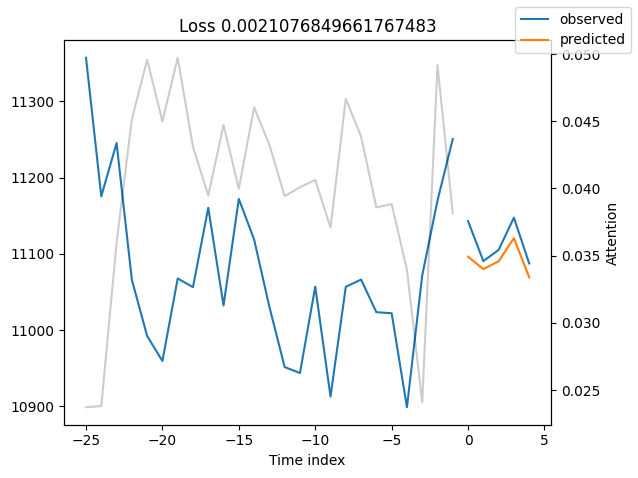

In [64]:
if not grid_search:
    preds = tft_predict(tft, val_dataloader)


## GRID SEARCH

In [65]:
# from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# study = optimize_hyperparameters(
#     train_dataloader,
#     val_dataloader,
#     model_path="optuna_test",
#     n_trials=2,
#     max_epochs=2,
#     gradient_clip_val_range=(0.01, 1.0),
#     hidden_size_range=(8, 128),
#     hidden_continuous_size_range=(8, 128),
#     attention_head_size_range=(1, 4),
#     learning_rate_range=(0.001, 0.1),
#     dropout_range=(0.1, 0.3),
#     trainer_kwargs=dict(limit_train_batches=30),
#     reduce_on_plateau_patience=4,
#     use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
# )
# print(f"Mejores hiperparámetros hallados: {study.best_trial.params}")
# best_hyperparameters = study.best_trial.params


In [66]:
if grid_search:
    study, best_tft = run_hyperparameter_optimization(train, train_dataloader, val_dataloader, n_trials=1, max_epochs=2, **hyperparams_grid)
    print(study.best_trial.params)

Podemos cortar la ejecucion y reanudarla posteriormente si habilitamos las siguientes lineas.

### EVAL BEST FOUND MODEL

In [67]:
if grid_search:
    tft_predict(best_tft, val_dataloader, n_preds=1)


# TEST EVAL

In [68]:
def make_preds(
    train,
    test,
    model,
    encoder_lenght,
    test_lenght,
    pred_lenght,
    quantiles: bool = True,
):
    test["target"] = 0
    # group = model.output_transformer.groups[0]
    if quantiles:
        try:  # for Quantileloss
            preds = []
            preds_data = pd.concat([train[-encoder_lenght:], test])
            for i in range(0, test_lenght, pred_lenght):
                new_data = preds_data[i : i + encoder_lenght + pred_lenght]
                new_data.loc[:, group] = new_data.iloc[0, new_data.columns.get_loc(group)]
                new_raw_predictions = model.predict(new_data, mode="raw", return_x=True)
                prediction = []
                for i in range(pred_lenght):
                    prediction.append(float(new_raw_predictions.output.prediction[0][i][3]))
                preds.append(prediction)
        except:  # for MQF2DistributionLoss
            preds = []
            preds_data = pd.concat([train[-encoder_lenght:], test])
            for i in range(0, test_lenght, pred_lenght):
                new_data = preds_data[i : i + encoder_lenght + pred_lenght]
                new_data.loc[:, group] = new_data.iloc[0, new_data.columns.get_loc(group)]
                prediction = model.to_prediction(new_raw_predictions.output)[0].flatten().tolist()
                preds.append(prediction)
    else:
        preds = []
        preds_data = pd.concat([train[-encoder_lenght:], test])
        for i in range(0, test_lenght, pred_lenght):
            new_data = preds_data[i : i + encoder_lenght + pred_lenght]
            new_data.loc[:, group] = new_data.iloc[0, new_data.columns.get_loc(group)]
            new_raw_predictions = model.predict(new_data, mode="raw", return_x=True)
            prediction = new_raw_predictions.output.prediction[0].flatten().tolist()
            preds.append(prediction)

    return preds

In [69]:
# preds = []
# preds_data = pd.concat([data[-n_prev_len:], test])
# # preds_data = preds_data.ffill()
# preds_data["target"] = float(1)
# # preds_data.drop(columns=['target'], inplace=True)
# for i in range(0, test_len, pred_len):
#     new_data = preds_data[i : i + n_prev_len + pred_len]
#     new_data.loc[:, group] = new_data.iloc[0, new_data.columns.get_loc(group)]
#     new_raw_predictions = tft.predict(new_data, mode="raw", return_x=True)
#     prediction = new_raw_predictions.output.prediction[0].flatten().tolist()
#     preds.append(prediction)

In [74]:
preds = make_preds(
    train=data,
    test=test,
    model=tft,
    encoder_lenght=n_prev_len,
    test_lenght=test_len,
    pred_lenght=pred_len,
    quantiles=True if isinstance(loss, QuantileLoss) else False,
)

c:\Users\nvegamun\AppData\Local\anaconda3\envs\tft\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nvegamun\AppData\Local\anaconda3\envs\tft\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\nvegamun\AppData\Local\anaconda3\envs\tft\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\nvegamun\AppData\Local\anaconda3\envs\tft\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_worker

MAE: 56.759515625000134
MAPE: 0.005267875239174036
RMSE: 77.13127846598857


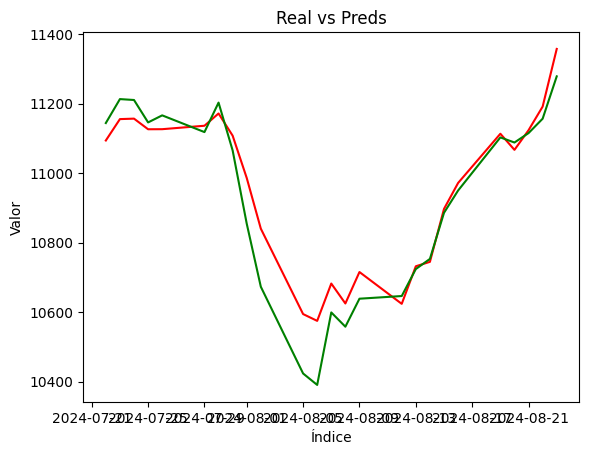

In [94]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error

dates = test["fechaHora"].to_list()
preds_flat = [item for sublist in preds for item in sublist]

# real_vals = list(data[-n_preds * pred_len :]["target"])
real_vals = test['target'].to_list()

print(f"MAE: {mean_absolute_error(real_vals, preds_flat)}")
print(f"MAPE: {mean_absolute_percentage_error(real_vals, preds_flat)}")
print(f"RMSE: {root_mean_squared_error(real_vals, preds_flat)}")

plt.plot(dates, preds_flat, color="r")
plt.plot(dates, real_vals, color="g")
plt.title("Real vs Preds")
plt.xlabel("Índice")
plt.ylabel("Valor")
plt.show()

MAE: 56.759515625000134
MAPE: 0.005267875239174036
RMSE: 77.13127846598857


c:\Users\nvegamun\AppData\Local\anaconda3\envs\tft\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


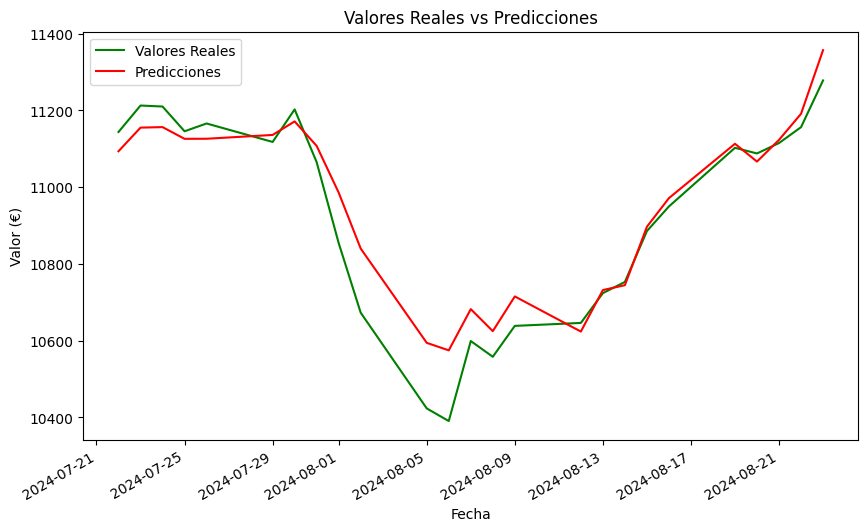

In [98]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import matplotlib.dates as mdates

# Convertir las fechas a formato de datetime si no están ya
dates = pd.to_datetime(test["fechaHora"]).to_list()

# Aplanar las predicciones si es necesario
preds_flat = [item for sublist in preds for item in sublist]

# Valores reales
real_vals = test["target"].to_list()

# Métricas de error
print(f"MAE: {mean_absolute_error(real_vals, preds_flat)}")
print(f"MAPE: {mean_absolute_percentage_error(real_vals, preds_flat)}")
print(f"RMSE: {mean_squared_error(real_vals, preds_flat, squared=False)}")

# Gráfico
plt.figure(figsize=(10, 6))
plt.plot(dates, real_vals, color="g", label="Valores Reales")
plt.plot(dates, preds_flat, color="r", label="Predicciones")
plt.title("Valores Reales vs Predicciones")
plt.xlabel("Fecha")
plt.ylabel("Valor (€)")

# Formato de fecha en el eje x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()  # Rotar fechas para mejor visualización

# Añadir leyenda
plt.legend()

# Mostrar gráfico
plt.show()

MAE: 56.759515625000134
MAPE: 0.005267875239174036
RMSE: 77.13127846598857


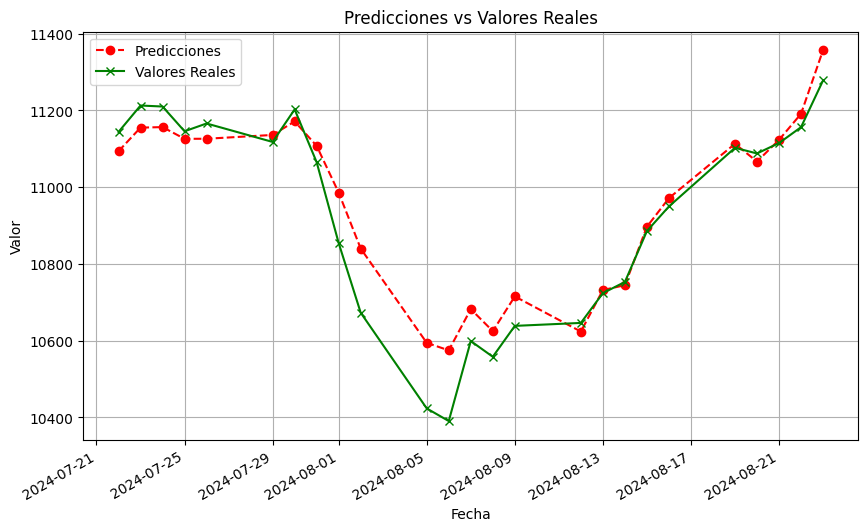

In [100]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Supongamos que `preds`, `test`, y `dates` ya están definidos en tu entorno

# Aplanar la lista de predicciones
preds_flat = [item for sublist in preds for item in sublist]

# Convertir los valores reales a una lista
real_vals = test["target"].to_list()

# Lista de fechas (timestamps)


# Calcular el error absoluto medio
print(f"MAE: {mean_absolute_error(real_vals, preds_flat)}")
print(f"MAPE: {mean_absolute_percentage_error(real_vals, preds_flat)}")
print(f"RMSE: {root_mean_squared_error(real_vals, preds_flat)}")
# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(dates, preds_flat, color="r", label="Predicciones", marker="o", linestyle="--")
plt.plot(dates, real_vals, color="g", label="Valores Reales", marker="x", linestyle="-")

# Añadir título y etiquetas
plt.title("Predicciones vs Valores Reales")
plt.xlabel("Fecha")
plt.ylabel("Valor")

# Formatear las fechas en el eje x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
# plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))
plt.gcf().autofmt_xdate()  # Rotar las etiquetas de fecha

# Añadir cuadrícula y leyenda
plt.grid(True)
plt.legend()

# Mostrar la gráfica
plt.show()

# INFERENCE

## Retrain for inference

In [78]:
features = [
    col for col in data.columns if col != "target"
]  # Columnas de características and col != 'fechaHora'

max_prediction_length = pred_len
max_encoder_length = n_prev_len  # 48
# training_cutoff = data["fechaHora"].max() - pd.Timedelta(hours=max_encoder_length)
training_cutoff = data["time_idx"].max() - max_prediction_length


retrain = TimeSeriesDataSet(
    full.dropna()[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="target",
    group_ids=[group],
    min_encoder_length=max_encoder_length,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    # min_prediction_length=24,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=[],  # group of categorical variables can be treated as one variable
    time_varying_known_reals=features,
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["target"],
    # lags={"target": list(range(1, 5))},
    # target_normalizer=GroupNormalizer("standard", groups=[group], transformation="softplus"),
    # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    allow_missing_timesteps=True,
    # add_encoder_length=True,
    # categorical_encoders={
    #     "month": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
    #     "week": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
    #     "day": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
    # },
)

revalidation = TimeSeriesDataSet.from_dataset(retrain, data, predict=True, stop_randomization=True)
# test = TimeSeriesDataSet.from_dataset(training, test_data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 64  # set this between 32 to 128
retrain_dataloader = retrain.to_dataloader(
    train=True, batch_size=batch_size, num_workers=7, persistent_workers=True
)
reval_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=7, persistent_workers=True
)
# test_dataloader = test.to_dataloader(train=False, batch_size=batch_size, num_workers=11, persistent_workers=True)
if not grid_search:
    # tft_params['learning_rate'] = 0.01
    retft, val_loss = tft_trainer(
        retrain, retrain_dataloader, reval_dataloader, max_epochs=epochs, **tft_params
    )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\nvegamun\AppData\Local\anaconda3\envs\tft\lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\nvegamun\AppData\Local\anaconda3\envs\tft\lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | MAPE                            | 0      | train
1  | loggin

c:\Users\nvegamun\AppData\Local\anaconda3\envs\tft\lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Exception ignored in: <function _ConnectionBase.__del__ at 0x000001DFA3555750>
Traceback (most recent call last):
  File "c:\Users\nvegamun\AppData\Local\anaconda3\envs\tft\lib\multiprocessing\connection.py", line 132, in __del__
    self._close()
  File "c:\Users\nvegamun\AppData\Local\anaconda3\envs\tft\lib\multiprocessing\connection.py", line 277, in _close
    _CloseHandle(self._handle)
OSError: [WinError 6] Controlador no válido


Epoch 74: 100%|██████████| 12/12 [00:09<00:00,  1.33it/s, v_num=97, train_loss_step=0.00455, val_loss=0.00182, train_loss_epoch=0.00437]

`Trainer.fit` stopped: `max_epochs=75` reached.


Epoch 74: 100%|██████████| 12/12 [00:09<00:00,  1.29it/s, v_num=97, train_loss_step=0.00455, val_loss=0.00182, train_loss_epoch=0.00437]
Number of parameters in network: 413.1k


In [92]:
new_data = full[-30:]
new_data.loc[:, group] = new_data.iloc[0, new_data.columns.get_loc(group)]
new_data['target'] = 1
new_raw_predictions = retft.predict(new_data, mode="raw", return_x=True)
if isinstance(loss, QuantileLoss):
    prediction = []
    for i in range(pred_len):
        prediction.append(float(new_raw_predictions.output.prediction[0][i][3]))
else:
    prediction = new_raw_predictions.output.prediction[0].flatten().tolist()
prediction

c:\Users\nvegamun\AppData\Local\anaconda3\envs\tft\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nvegamun\AppData\Local\anaconda3\envs\tft\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\nvegamun\AppData\Local\anaconda3\envs\tft\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[11140.525390625,
 11129.8125,
 11221.5185546875,
 11299.2353515625,
 11445.8662109375]

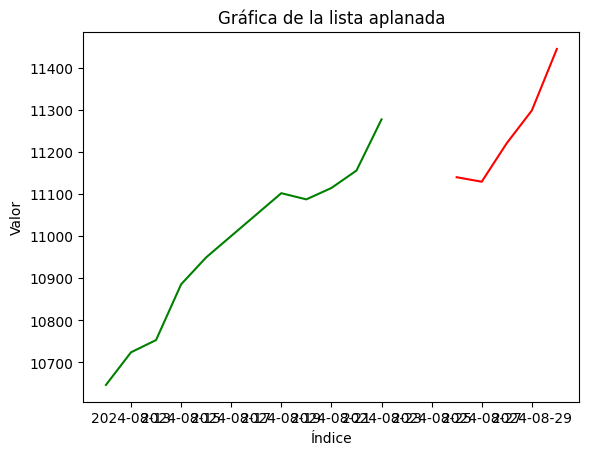

In [93]:
# prediction = [11233.22265625, 11129.837890625, 11228.3486328125, 11315.59375, 11555.85546875]
last_vals = full[-10:]
last_vals = last_vals[["fechaHora", "target"]]
fechas_azul = pd.date_range(start="2024-08-26", periods=len(prediction))
predictions = pd.DataFrame({"fechaHora": fechas_azul, "target": prediction})

plt.plot(predictions['fechaHora'], predictions['target'], color="r")
plt.plot(last_vals["fechaHora"], last_vals["target"], color="g")
plt.title("Gráfica de la lista aplanada")
plt.xlabel("Índice")
plt.ylabel("Valor")
plt.show()

# INTERPRETABILITY

In [ ]:
interpretation = tft.interpret_output(preds.output, reduction="sum") #
tft.plot_interpretation(interpretation)


AttributeError: 'list' object has no attribute 'output'